# Neural Network Classification: MNIST Dataset

이 노트북에서는 **MNIST 손글씨 숫자 (0~9)** 데이터셋을 활용하여 신경망 분류 모델을 학습합니다.

## 목표
1. 데이터 불러오기 및 전처리
2. Neural Network 모델 정의
3. 학습 및 학습 곡선 확인
4. 성능 평가 및 예측 시각화

## MNIST 데이터셋 소개
- **내용**: 손글씨 숫자 이미지 (0부터 9까지)
- **크기**: 28x28 픽셀의 흑백 이미지
- **훈련 데이터**: 60,000개 이미지
- **테스트 데이터**: 10,000개 이미지
- **분류**: 10개 클래스 (0~9)


## 📚 MNIST 신경망 분류 가이드

이 노트북의 각 셀에 대한 상세한 설명입니다.


In [2]:
# matplotlib 폰트 깨짐 현상 해결
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

# 사용 가능한 한글 폰트 찾기
font_list = [f.name for f in fm.fontManager.ttflist]
korean_fonts = [f for f in font_list if any(keyword in f.lower() for keyword in ['apple', 'nanum', 'malgun', 'gothic', 'dotum'])]

# 가장 적합한 한글 폰트 선택
if 'Apple SD Gothic Neo' in korean_fonts:
    selected_font = 'Apple SD Gothic Neo'
elif 'Nanum Myeongjo' in korean_fonts:
    selected_font = 'Nanum Myeongjo'
elif 'AppleGothic' in korean_fonts:
    selected_font = 'AppleGothic'
elif 'Malgun Gothic' in korean_fonts:
    selected_font = 'Malgun Gothic'
else:
    selected_font = korean_fonts[0] if korean_fonts else 'DejaVu Sans'

# 폰트 설정 적용
plt.rcParams.update({
    'font.family': selected_font,
    'font.size': 10,
    'axes.unicode_minus': False,
    'figure.autolayout': True,
    'axes.grid': True,
    'grid.alpha': 0.3
})

print(f"선택된 폰트: {selected_font}")
print("한글 폰트 설정 완료!")

선택된 폰트: Apple SD Gothic Neo
한글 폰트 설정 완료!


In [3]:
# 필요한 라이브러리 import
import tensorflow as tf              # 딥러닝 프레임워크
import numpy as np                   # 수치 연산
import matplotlib.pyplot as plt      # 시각화
from tensorflow.keras.utils import to_categorical  # One-hot 인코딩 함수
from tensorflow.keras.datasets import mnist        # MNIST 데이터셋

print(f"TensorFlow 버전: {tf.__version__}")

TensorFlow 버전: 2.12.0


## 1. 데이터 불러오기

In [4]:
# MNIST 데이터셋 불러오기
# mnist.load_data()는 (X_train, y_train), (X_test, y_test) 형태로 반환
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 원본 데이터 형태 확인
# X_train: (60000, 28, 28) - 28x28 픽셀의 훈련 이미지 60,000개
# y_train: (60000,) - 각 이미지의 정답 라벨 (0~9)
print("원본 데이터 shape:", X_train.shape, y_train.shape)
print("훈련 샘플 수:", X_train.shape[0])
print("테스트 샘플 수:", X_test.shape[0])

원본 데이터 shape: (60000, 28, 28) (60000,)
훈련 샘플 수: 60000
테스트 샘플 수: 10000


## 2. 데이터 전처리

In [5]:
# ===================== 데이터 전처리 =====================

# 1. 픽셀값 정규화 (0~255 → 0~1)
# 이미지 픽셀 값이  footprint를 0~1로 정규화 (신경망 학습에 안정적)
X_train = X_train.astype("float32") / 255.0  # float32로 변환 후 255로 나눔
X_test = X_test.astype("float32") / 255.0

# 2. 이미지 벡터화 (28x28 → 784)
# 2D 이미지를 1D 벡터로 변환 (Fully Connected Layer에 입력하기 위해)
X_train = X_train.reshape(-1, 28*28)  # (60000, 784)
X_test = X_test.reshape(-1, 28*28)    # (10000, 784)

# 3. One-hot 인코딩
# 정답 라벨을 원-핫 벡터로 변환
y_train = to_categorical(y_train, 10)  # (60000, 10)
y_test = to_categorical(y_test, 10)    # (10000, 10)

print("전처리 후 shape:", X_train.shape, y_train.shape)

전처리 후 shape: (60000, 784) (60000, 10)


## 3. 모델 정의

In [8]:
# ===================== 신경망 모델 정의 =====================

# Sequential 모델: 레이어를 순차적으로 쌓는 간단한 구조
model = tf.keras.Sequential([
    # 입력층 (Input Layer)
    # - 784개의 픽셀 값을 입력으로 받음 (28x28=784)
    # - 각 픽셀은 0~1 사이의 정규화된 값
    tf.keras.layers.InputLayer(input_shape=(784,)),
    
    # 은닉층 1 (Hidden Layer 1)
    # - 256개의 뉴런(노드)을 가진 완전연결층
    # - ReLU 활성화 함수: f(x) = max(0, x)
    #   * 음수 입력은 0으로, 양수 입력은 그대로 출력
    #   * 기울기 소실 문제를 완화하고 학습 속도 향상
    tf.keras.layers.Dense(256, activation="relu"),
    
    # 은닉층 2 (Hidden Layer 2)
    # - 128개의 뉴런을 가진 완전연결층
    # - 점진적으로 뉴런 수를 줄여서 특징을 압축
    # - ReLU 활성화 함수 사용
    tf.keras.layers.Dense(128, activation="relu"),
    
    # 출력층 (Output Layer)
    # - 10개의 뉴런 (0~9 숫자 분류를 위해)
    # - Softmax 활성화 함수: 확률 분포로 변환
    #   * 모든 출력의 합이 1이 되도록 정규화
    #   * 가장 높은 확률을 가진 클래스가 예측 결과
    tf.keras.layers.Dense(10, activation="softmax")
])

# 모델 구조 요약 출력
# - 각 레이어의 파라미터 수와 전체 파라미터 수 확인
model.summary()

print("\n=== 모델 구조 설명 ===")
print("입력층: 784개 픽셀 (28x28 이미지)")
print("은닉층1: 256개 뉴런 (ReLU 활성화)")
print("은닉층2: 128개 뉴런 (ReLU 활성화)")
print("출력층: 10개 뉴런 (Softmax 활성화)")
print("총 파라미터 수: 약 25만개")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________

=== 모델 구조 설명 ===
입력층: 784개 픽셀 (28x28 이미지)
은닉층1: 256개 뉴런 (ReLU 활성화)
은닉층2: 128개 뉴런 (ReLU 활성화)
출력층: 10개 뉴런 (Softmax 활성화)
총 파라미터 수: 약 25만개


## 4. 모델 컴파일

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## 5. 모델 학습

In [24]:
# ===================== 모델 학습 =====================

# 모델 학습 시작
# fit() 메서드로 훈련 데이터를 사용하여 모델 학습
history = model.fit(
    X_train, y_train,           # 훈련 데이터 (입력, 정답)
    epochs=10,                  # 전체 데이터셋을 10번 반복 학습
    batch_size=128,             # 한 번에 128개 샘플씩 처리 (미니배치)
    validation_split=0.2,       # 훈련 데이터의 20%를 검증용으로 분리
    verbose=1                   # 학습 진행 상황 출력 (1: 상세, 0: 출력 없음)
)

print("\n=== 학습 완료 ===")
print("총 Epoch 수: 10")
print("배치 크기: 128")
print("검증 데이터 비율: 20%")
print("375 steps per epoch (60000/128 = 469, validation_split 고려)")

Epoch 1/10
375/375 [==============================] - 1s 1ms/step - loss: 2.5505e-07 - accuracy: 1.0000 - val_loss: 0.2239 - val_accuracy: 0.9786
Epoch 2/10
375/375 [==============================] - 1s 1ms/step - loss: 2.1539e-07 - accuracy: 1.0000 - val_loss: 0.2238 - val_accuracy: 0.9790
Epoch 3/10
375/375 [==============================] - 1s 1ms/step - loss: 1.7880e-07 - accuracy: 1.0000 - val_loss: 0.2270 - val_accuracy: 0.9787
Epoch 4/10
375/375 [==============================] - 1s 1ms/step - loss: 1.4684e-07 - accuracy: 1.0000 - val_loss: 0.2286 - val_accuracy: 0.9787
Epoch 5/10
375/375 [==============================] - 1s 1ms/step - loss: 1.2488e-07 - accuracy: 1.0000 - val_loss: 0.2299 - val_accuracy: 0.9791
Epoch 6/10
375/375 [==============================] - 1s 1ms/step - loss: 1.0338e-07 - accuracy: 1.0000 - val_loss: 0.2330 - val_accuracy: 0.9787
Epoch 7/10
375/375 [==============================] - 1s 1ms/step - loss: 8.6452e-08 - accuracy: 1.0000 - val_loss: 0.2333 -

## 6. 학습 곡선 확인

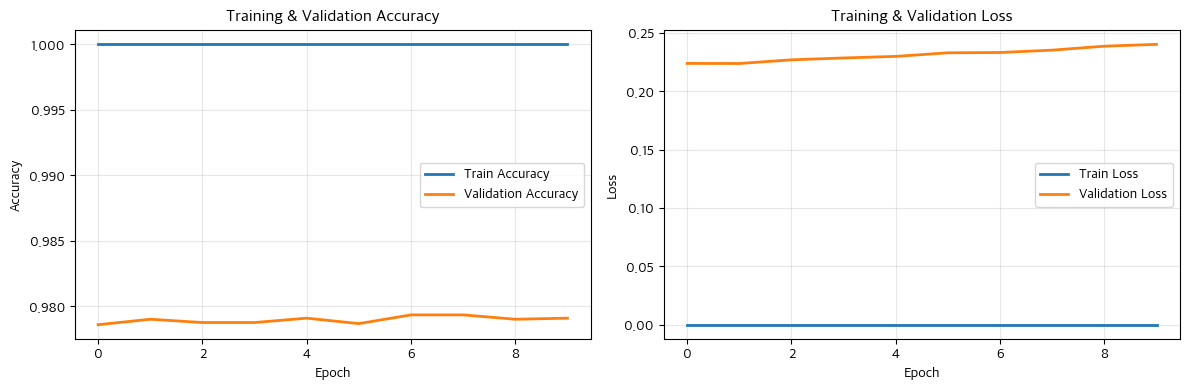

=== 학습 결과 분석 ===
최종 훈련 정확도: 1.0000
최종 검증 정확도: 0.9791
최종 훈련 손실: 0.0000
최종 검증 손실: 0.2403
✅ 과적합 없이 잘 학습되었습니다.


In [26]:
# ===================== 학습 곡선 시각화 =====================

# 정확도(Accuracy) 곡선 그리기
plt.figure(figsize=(12, 4))

# 첫 번째 서브플롯: 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy", linewidth=2)
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.grid(True, alpha=0.3)

# 두 번째 서브플롯: 손실(Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss", linewidth=2)
plt.plot(history.history['val_loss'], label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 학습 결과 분석
print("=== 학습 결과 분석 ===")
print(f"최종 훈련 정확도: {history.history['accuracy'][-1]:.4f}")
print(f"최종 검증 정확도: {history.history['val_accuracy'][-1]:.4f}")
print(f"최종 훈련 손실: {history.history['loss'][-1]:.4f}")
print(f"최종 검증 손실: {history.history['val_loss'][-1]:.4f}")

# 과적합 여부 확인
if history.history['val_accuracy'][-1] < history.history['accuracy'][-1] - 0.05:
    print("⚠️ 과적합(Overfitting) 징후가 보입니다.")
else:
    print("✅ 과적합 없이 잘 학습되었습니다.")

## 7. 모델 평가

In [27]:
# ===================== 모델 평가 =====================

# 테스트 데이터로 모델 성능 평가
# evaluate() 메서드: 테스트 데이터에 대한 손실과 정확도 계산
loss, acc = model.evaluate(X_test, y_test, verbose=0)

print("=== 모델 성능 평가 ===")
print(f"테스트 정확도: {acc:.3f} ({acc*100:.1f}%)")
print(f"테스트 손실: {loss:.3f}")

# 성능 해석
if acc >= 0.95:
    print("🎉 매우 우수한 성능!")
elif acc >= 0.90:
    print("👍 좋은 성능!")
elif acc >= 0.80:
    print("👌 괜찮은 성능")
else:
    print("⚠️ 성능 개선이 필요합니다.")

=== 모델 성능 평가 ===
테스트 정확도: 0.981 (98.1%)
테스트 손실: 0.207
🎉 매우 우수한 성능!


## 8. 예측 예시 시각화

313/313 [==============================] - 0s 351us/step
=== 예측 결과 시각화 ===
첫 10개 테스트 샘플의 예측 결과:


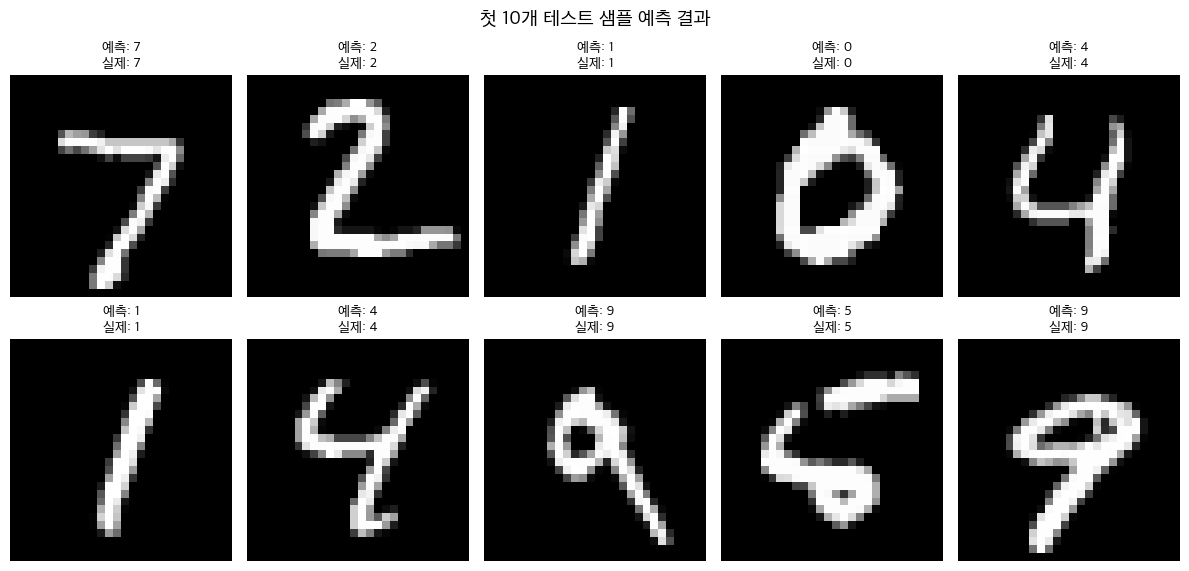


총 193개 샘플이 잘못 예측되었습니다.
정확도: 98.1%

잘못 예측된 샘플들:


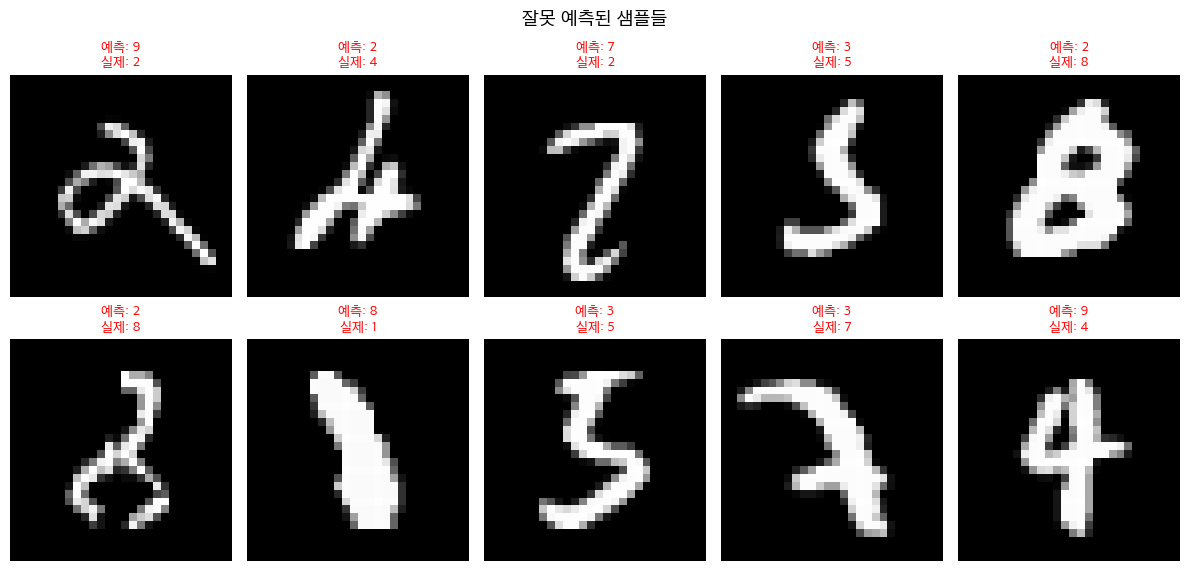

In [28]:
# ===================== 예측 결과 시각화 =====================

# 테스트 데이터에 대한 예측 수행
# predict() 메서드: 각 클래스에 대한 확률을 반환
y_pred = model.predict(X_test)

# 예측 결과를 클래스 인덱스로 변환
# argmax(): 가장 높은 확률을 가진 클래스의 인덱스 반환
y_pred_classes = np.argmax(y_pred, axis=1)

# 실제 정답도 클래스 인덱스로 변환
y_true = np.argmax(y_test, axis=1)

print("=== 예측 결과 시각화 ===")
print("첫 10개 테스트 샘플의 예측 결과:")

# 첫 10개 샘플 시각화
idx = 0
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    # 이미지를 28x28로 reshape하여 표시
    plt.imshow(X_test[i+idx].reshape(28, 28), cmap="gray")
    # 제목에 예측값과 실제값 표시
    plt.title(f"예측: {y_pred_classes[i+idx]}\n실제: {y_true[i+idx]}", fontsize=10)
    plt.axis("off")
plt.suptitle("첫 10개 테스트 샘플 예측 결과", fontsize=14)
plt.tight_layout()
plt.show()

# 잘못 예측된 샘플들 찾기
failed = y_pred_classes != y_true
failed_idx = np.where(failed)[0]

print(f"\n총 {len(failed_idx)}개 샘플이 잘못 예측되었습니다.")
print(f"정확도: {(len(y_test) - len(failed_idx))/len(y_test)*100:.1f}%")

# 잘못 예측된 샘플들 시각화
if len(failed_idx) > 0:
    print("\n잘못 예측된 샘플들:")
    plt.figure(figsize=(12, 6))
    for i in range(min(10, len(failed_idx))):  # 최대 10개만 표시
        plt.subplot(2, 5, i+1)
        plt.imshow(X_test[failed_idx[i]].reshape(28, 28), cmap="gray")
        plt.title(f"예측: {y_pred_classes[failed_idx[i]]}\n실제: {y_true[failed_idx[i]]}", 
                 fontsize=10, color='red')
        plt.axis("off")
    plt.suptitle("잘못 예측된 샘플들", fontsize=14)
    plt.tight_layout()
    plt.show()


## 🤔 생각해보기

### 과적합(Overfitting) 분석
- **Training/Validation Graph에서 과적합 징후가 보이나?**

#### 과적합 판단 기준:
1. **검증 정확도 < 훈련 정확도**: 검증 성능이 훈련 성능보다 낮음
2. **검증 손실 증가**: 검증 손실이 증가하는 추세
3. **성능 격차**: 훈련과 검증 성능 간의 큰 차이

#### 과적합 해결 방법:
- **드롭아웃(Dropout)**: 일부 뉴런을 랜덤하게 비활성화
- **정규화(Regularization)**: L1, L2 정규화 적용
- **데이터 증강(Data Augmentation)**: 더 많은 훈련 데이터 생성
- **조기 종료(Early Stopping)**: 검증 성능이 개선되지 않으면 학습 중단
- **모델 복잡도 감소**: 레이어 수나 뉴런 수 줄이기

### 모델 개선 방안:
1. **더 깊은 네트워크**: 더 많은 은닉층 추가
2. **배치 정규화**: 학습 안정성 향상
3. **다른 활성화 함수**: Leaky ReLU, ELU 등 시도
4. **앙상블**: 여러 모델의 예측 결합